In [1]:
#First, we choose the pretrained model to use 

model_id = "google/vit-base-patch16-224"
#model_id = 'microsoft/swin-tiny-patch4-window7-224'
#model_id = 'facebook/deit-base-patch16-224'
#model_id = 'microsoft/resnet-50'


Now we load the feature extractor to process the image into a tensor.

In [2]:
from transformers import AutoFeatureExtractor, ViTFeatureExtractor, DeiTFeatureExtractor
#feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)
#feature_extractor = DeiTFeatureExtractor.from_pretrained(model_id)

/home/studio-lab-user/.conda/envs/PRUEBA/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This feature extractor will resize every image to the resolution that the model expects and normalize channels. 

We define 2 functions, one for training and one for validation, including resizing, center cropping and normalizing.

In [3]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["img"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["img"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions.

In [4]:
#Load data
import datasets
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
ds = load_from_disk('./fillfactor_dict')
ds

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 2044
    })
    val: Dataset({
        features: ['img', 'label'],
        num_rows: 228
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 402
    })
})

In [5]:
# split up training into training + validation
train_ds = ds['train']
val_ds = ds['val']
test_ds = ds['test']

In [6]:
#Classes names
labels = train_ds.features["label"].names
print(labels)

['gamma', 'proton']


In [7]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Parameter 'transform'=<function preprocess_train at 0x7f132e8eedc0> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [8]:
train_ds[0]

{'img': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=288x288>,
 'label': 1,
 'pixel_values': tensor([[[0.9686, 0.9686, 0.9686,  ..., 1.0000, 1.0000, 1.0000],
          [0.9843, 0.9765, 0.9765,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 0.9843, 0.9765,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.9608, 0.9608, 0.9608,  ..., 1.0000, 1.0000, 1.0000],
          [0.9765, 0.9686, 0.9686,  ..., 1.0000, 1.0000, 1.0000],
          [0.9843, 0.9765, 0.9686,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.9451, 0.9451, 0.9451,  ..., 1.0000, 1.0000, 1.0000],
    

Now that our data is ready, we can download the pretrained model and fine-tune it. We use the modelViTForImageClassification.  

In [9]:
#We create a dictionary that maps a label name to an integer and vice versa. 
#The mapping will help the model recover the label name from the label number.

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [10]:
from transformers import ViTForImageClassification, SwinForImageClassification,ResNetForImageClassification, TrainingArguments, Trainer, SegformerForImageClassification

model = ViTForImageClassification.from_pretrained(model_id,
                                                 label2id=label2id,
                                                 id2label=id2label,
                                                 ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
                                                 )

#model = SwinForImageClassification.from_pretrained(model_id,
#                                                 label2id=label2id,
#                                                 id2label=id2label,
#                                                 ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
#) 

#model = ResNetForImageClassification.from_pretrained(model_id,
#                                                 label2id=label2id,
#                                                 id2label=id2label,
#                                                 ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
#)




Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the classifier layer) and randomly initializing some other (the weights and bias of a new classifier layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a Trainer, we will need to define the training configuration and the evaluation metric. The most important is the TrainingArguments, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is remove_unused_columns=False. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [11]:
model_name = model_id.split("/")[-1]
batch_size = 32
learning_rate = 5e-5
gradient_accumulation_steps = 4
epochs = 3
warmup_ratio= 0.1
logging_steps=10

args = TrainingArguments(
    f"{model_name}-finetuned-ds",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    warmup_ratio=warmup_ratio,
    logging_steps=logging_steps,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
   # push_to_hub=True,
)

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the metric we loaded earlier. Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [12]:
import numpy as np

from datasets import load_metric

metric = load_metric("accuracy")

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a collate_fn, which will be used to batch examples together. Each batch consists of 2 keys, namely pixel_values and labels.

In [13]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the Trainer:

In [14]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Now we can finetune our model by calling the train method:

In [15]:
train_results = trainer.train()


/home/studio-lab-user/.conda/envs/PRUEBA/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2044
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 48


Epoch,Training Loss,Validation Loss,Accuracy
1,0.614100,0.549476,0.728070
2,0.503500,0.373794,0.929825
3,0.419500,0.279482,0.929825


***** Running Evaluation *****
  Num examples = 228
  Batch size = 32
Saving model checkpoint to vit-base-patch16-224-finetuned-ds/checkpoint-16
Configuration saved in vit-base-patch16-224-finetuned-ds/checkpoint-16/config.json
Model weights saved in vit-base-patch16-224-finetuned-ds/checkpoint-16/pytorch_model.bin
Feature extractor saved in vit-base-patch16-224-finetuned-ds/checkpoint-16/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 228
  Batch size = 32
Saving model checkpoint to vit-base-patch16-224-finetuned-ds/checkpoint-32
Configuration saved in vit-base-patch16-224-finetuned-ds/checkpoint-32/config.json
Model weights saved in vit-base-patch16-224-finetuned-ds/checkpoint-32/pytorch_model.bin
Feature extractor saved in vit-base-patch16-224-finetuned-ds/checkpoint-32/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 228
  Batch size = 32
Saving model checkpoint to vit-base-patch16-224-finetuned-ds/checkpoint-48
Configuration saved i

In [16]:

metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 228
  Batch size = 32


***** eval metrics *****
  epoch                   =       2.98
  eval_accuracy           =     0.9956
  eval_loss               =     0.0158
  eval_runtime            = 0:00:39.39
  eval_samples_per_second =      5.787
  eval_steps_per_second   =      0.203


In [16]:

test_ds.set_transform(preprocess_val)

In [17]:
outputs = trainer.predict(test_ds)
y_pred = outputs.predictions.argmax(1)

***** Running Prediction *****
  Num examples = 402
  Batch size = 32


In [18]:
compute_metrics(outputs)

{'accuracy': 0.9427860696517413}

In [19]:
outputs

PredictionOutput(predictions=array([[-1.14416218e+00,  9.55663323e-01],
       [-7.81753004e-01,  1.39746928e+00],
       [ 4.33955699e-01, -2.71643519e-01],
       [-4.19816971e-01,  4.27662671e-01],
       [-3.61591727e-01,  5.79687834e-01],
       [-3.39747012e-01,  5.35327137e-01],
       [-9.82848287e-01,  8.41285706e-01],
       [-9.82541800e-01,  9.30580378e-01],
       [-1.84639841e-02,  2.40253806e-01],
       [ 6.89258933e-01, -1.49669632e-01],
       [-2.89360732e-02,  3.38356018e-01],
       [-5.91232657e-01,  6.79622173e-01],
       [ 5.21820545e-01, -1.86477304e-01],
       [ 2.11738199e-01, -1.77288875e-01],
       [ 4.45146501e-01, -2.48431981e-01],
       [-4.23141360e-01,  8.13230753e-01],
       [-4.12879646e-01,  5.15477777e-01],
       [-5.39735198e-01,  4.59055185e-01],
       [-1.03144836e+00,  1.01251948e+00],
       [-7.00994551e-01,  9.35009360e-01],
       [ 5.22156239e-01, -2.66043007e-01],
       [-8.67330551e-01,  9.14246917e-01],
       [-3.60703200e-01, 

In [20]:
y_pred

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,

In [21]:
y_true = np.array(test_ds[:]['label'])
y_true

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[102,   7],
       [ 16, 277]])

In [23]:
np.where(y_true!=y_pred)

(array([ 23,  86,  97, 110, 115, 153, 181, 190, 241, 246, 257, 272, 280,
        298, 315, 335, 340, 351, 359, 361, 373, 395, 399]),)

In [24]:
y_true[23]

1

In [25]:
id2label[str(1)]

'proton'

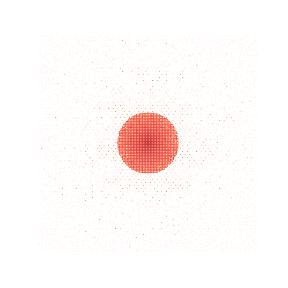

In [26]:
test_ds[23]['img']